# Reconhecimento facial
<small> Guilherme Monteiro e Vinícius Cavalcante <small>

Neste Notebook será feito o PCA de imagens de rostos. O PCA irá gerar Eigenfaces para extrair as características principais de uma face humana. O PCA das faces será feito em cima do banco de dados *Labeled Faces in the Wild* (LFW).

In [1]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
import html
import pandas as pd
import seaborn as sns
from google.colab import files
import os

# LFW

*Labeled Faces in the Wild* (LFW) é um banco de dados público de imagens de faces feito justamente para facilitar aplicações de reconhecimento facial. Há quatro conjuntos diferentes de imagens LFW: o original e três tipos diferentes de imagens "alinhadas". De acordo com os pesquisadores, as imagens com alinhamento tipo afunilamento profundo (*deep funneling*) produziram resultados superiores para a maioria dos algoritmos de verificação de rosto em comparação com os outros tipos de imagem. Portanto, o conjunto de dados carregado aqui é essa versão.

 ![](https://drive.google.com/uc?export=view&id=1cxwNxh8184bDWBVAAxQohL4YHCvYJrb0)

<small> Imagem extraída do [link](https://github.com/dribnet/lfw_fuel).

Abaixo, o conjunto de dados de pessoas LFW é carregado com o parâmetro `resize` que indica a proporção na qual a imagem é redimensionada.
```
lfw_people = fetch_lfw_people(resize=0.5)
```

A escolha do `resize` de 0.5 levou a uma dimensão total de $62\times 47 = 2914$ para cada ponto do espaço (imagem). Além disso, a escolha do parâmetro default  `min_faces_per_person = None` fez com que não houvesse número mínimo de fotos da mesma pessoa para que ela fosse filtrada, o que retornou um conjunto de 13233 imagens no total.

A variável `lfw_people.images` contém os dados referentes às imagens e a variável `lfw_people.target` contém um número referente à identificação da imagem. A conexão entre os números usados na identificação e o nome de cada pessoa é obtida através da variável `lfw_people.target_names`. 

A matriz 2D `lfw_people.data` contém o número de linhas equivalente ao número de imagens e o número de colunas equivalente à dimensão (número de características) de cada imagem.




In [2]:
from sklearn.datasets import fetch_lfw_people
resize = 0.5 #1
lfw_people = fetch_lfw_people(resize=resize)

O dataset contém  13233 imagens de dimensões  62 por 47
Portanto, o número de características (dimensão) de cada imagem é 62x47 = 2914
As 13233 imagens são de 5749 pessoas diferentes.


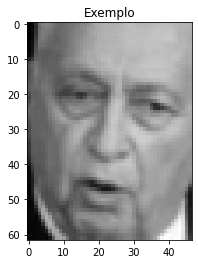

Todos os dados estão resumidos em uma matriz de 13233 linhas por 2914 colunas.


In [3]:
cont_imagens, altura_lfw, largura_lfw = lfw_people.images.shape
n_classes = lfw_people.target_names.shape[0]

print(f'O dataset contém ',cont_imagens, 'imagens de dimensões ', altura_lfw, 'por', largura_lfw)
print(f'Portanto, o número de características (dimensão) de cada imagem é {altura_lfw}x{largura_lfw} = {lfw_people.data.shape[1]}')

print(f'As {cont_imagens} imagens são de {n_classes} pessoas diferentes.')

plt.imshow(lfw_people.images[cont_imagens-2], cmap='gray')
plt.title('Exemplo')
plt.show()
print(f'Todos os dados estão resumidos em uma matriz de {lfw_people.data.shape[0]} linhas por {lfw_people.data.shape[1]} colunas.')

O dataset é composto das mais diversas faces de figuras públicas, englobando variados gêneros, etnias, idades e biotipos, tornando o PCA amplo para formar faces de qualquer ser humano a partir das componentes aqui calculadas.

 ![](https://drive.google.com/uc?export=view&id=1Gdql6Kl3V8WlBRcZsIn8LPrUVa1DjnTi)




# PCA

O objeto `PCA` da biblioteca `sklearn` faz a decomposição em componentes principais de uma amostra.

O seu construtor tem a sintaxe `decomposition.PCA()`. O parâmetro opcional `n_components` especifica a quantidade de componentes a ser obtida na decomposição. Se omitido, ele retorna o mínimo entre a quantidade de pontos da amostra e a dimensão da amostra.

Um conjunto de dados pode ser decomposto com o método `fit(dados)` onde `dados` é uma matriz cujas linhas são pontos do espaço amostral.

O objeto retornado possui os atributos `mean_` com o ponto médio, `components_` com uma matriz cujas linhas são os autovetores da matriz de covariância e `explained_variance_` que corresponde aos autovalores da matriz de covariância dos dados. `explained_variance_ratio_` retorna a porcentagem de variação explicada por cada um dos componentes selecionados. 

Os dados referem-se a imagens com dimensão de 2914, uma dimensão para cada pixel. Ao aplicar PCA, pode-se reduzir a dimensão dos pontos de `lfw_people.data` a uma dimensão de `n_PC` componentes retendo-se o *máximo* de informação possível. Através da plotagem da porcentagem de variação explicada acumulada, é possível verificar qual o valor razoável para `n_PC`. Para encontrar as direções principais, passa-se o parâmetro `n_components=n_PC` no construtor de `PCA` e cria-se uma nova decomposição de `lfw_people.data` com o método `fit`.

Depois, os dados projetados no novo espaço de dimensão reduzida são obtidos a partir de pontos no espaço original com o método `transform` (aqui há alguma perda de informação, porém minimizada por estarmos escolhendo um `n_PC` que mantém boa parte da variância das imagens). 

A medida que o número de componentes consideradas cresce, a imagem recuperada se aproxima da imagem original. Um ponto do espaço original pode ser obtido a partir do espaço reduzido com o método `inverse_transform`. 



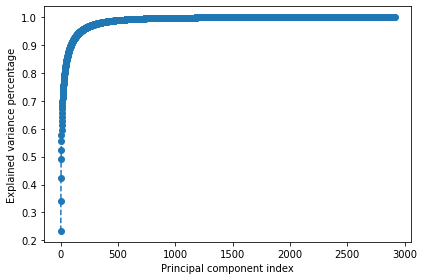

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(lfw_people.data)
cumulativeValue = pca.explained_variance_ratio_.cumsum() 

plt.plot(range(0,len(cumulativeValue)), cumulativeValue, marker = 'o', linestyle="--")

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')

plt.tight_layout()

Será utilizado `n_CP = 200`, sugerido pelo gráfico gerado, pois:

In [5]:
print('De acordo com a variância acumulada, 400 componentes principais explicam aproximadamente {:6.2f}% da variância total'. format(cumulativeValue[399]*100))

De acordo com a variância acumulada, 400 componentes principais explicam aproximadamente  98.40% da variância total


In [6]:
n_PC = 200
pca = PCA(n_components = n_PC, whiten=True).fit(lfw_people.data)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


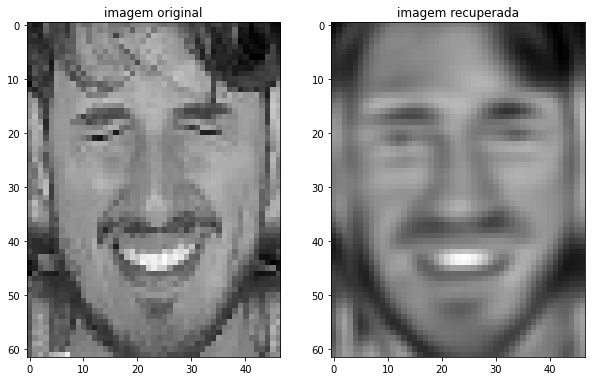

In [11]:
img_example = cv2.imread('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Imagens de autoria própria/g_sofrendo.jpg', cv2.IMREAD_GRAYSCALE)
img_example = cv2.resize(img_example, (largura_lfw, altura_lfw), interpolation=cv2.INTER_CUBIC)

transformada = pca.transform(img_example.reshape(1,-1))
recuperada = pca.inverse_transform(transformada).reshape(altura_lfw, largura_lfw)
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img_example, cmap='gray')
plt.title('imagem original')

plt.subplot(1,2,2)
plt.imshow(recuperada, cmap='gray')
plt.title('imagem recuperada')

plt.show()

Apenas para ilustração, pode-se remodelar nossos componentes PCA e definir `eigenfaces`, que é o nome dado a um conjunto de autovetores quando usado no problema de visão computacional de reconhecimento de rosto humano. Quando o PCA é aplicado, a dimensão de cada uma das 200 componentes é de 2914 (número de pixeis) e, para mostrar a imagem,  remodelamos o vetor para dimensão de `altura_lfw` vs `largura_lfw`.

In [ ]:
eigenfaces = pca.components_.reshape((n_PC, altura_lfw, largura_lfw))
print(eigenfaces.shape)

Serão plotadas algumas `eigenfaces`. Elas são em tons escuros, dando ênfase no que é predominante no reconhecimento de uma face humana.

In [ ]:
plt.figure(figsize=(10, 15))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(eigenfaces[i], cmap=plt.cm.gray)
  plt.title(f'Eigenface {i}', size=12)
  plt.xticks(())
  plt.yticks(())
plt.show()

# Salva os dados do PCA

In [ ]:
#crie um diretório com o caminho a seu gosto...
#o "!mkdir -p (caminho) " vai criar o diretório se ele ainda não existir
!mkdir -p gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/

In [ ]:
!ls gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/

In [ ]:
import pickle as pk

In [ ]:
with open('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/pca_'+str(resize)+'.pkl', 'wb') as pickle_file:
   pk.dump(pca, pickle_file)